Let's try post-process to reduce the fragmentation we have in the optimal model. This way of improving was dicided after the progress report.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Simple smoothing

## Read data and predicted labels
We use the optimal model, SVC on rolling data.

In [2]:
y_df = pd.read_csv('results/roll_dev_y.csv', index_col=0)
y_df.head()

,y,y_lr,y_svc,y_rf,core_section
0,0,1,1,1,N11-2
1,0,1,1,1,N11-2
2,0,1,1,1,N11-2
3,0,1,1,1,N11-2
4,0,1,1,1,N11-2


## Functions for smoothing and evaluation

In [3]:
def smooth(y, groups, window):
    """
    This function smoothes the labels in each core section.
    y is the label array.
    groups is the core section list.
    window is the window size each time the function looking at.
    """
    y_s = []
    for core_section in np.unique(groups):
        y_g = y[groups == core_section]
        i = 0

        # the last elements not enough for a window size will be excluded 
        while (i + window) < len(y_g):
            value, count = np.unique(y_g[i: i+window], return_counts=True)
            # set the dominant value in the window as the values
            y_s = np.hstack((y_s, np.repeat(value[np.argmax(count)], window)))
            i += window
        # add the last part of data that can't be smoothed to the new array
        y_s = np.hstack((y_s, y_g[i:]))
    return y_s.astype(int)

In [97]:
def count_boundary(y, groups):
    """
    y is the label to count boundary within each section.
    groups is the core section.
    """
    bd = []
    for section in np.unique(groups):
        y_g = y[groups == section]
        for i in range(len(y_g) - 1):
            if y_g[i] != y_g[i+1]:
                bd.append(True)
            else:
                bd.append(False)
    return np.sum(bd)

In [5]:
count_boundary(y_df.y.values, y_df.core_section.values)

22

The boundary amount of human description is consistent to the way we did for illustrating conjunctions.

## Execute

In [8]:
%%time
from sklearn.metrics import balanced_accuracy_score as score
windows = []
scores = []
bds = []

for window in range(5, 200):
    windows.append(window)
    y_s = smooth(y_df.y_svc.values, y_df.core_section.values, window)
    scores.append(score(y_true=y_df.y, y_pred=y_s))
    bds.append(count_boundary(y_s, y_df.core_section.values))

windows = np.array(windows)
scores = np.array(scores)
bds = np.array(bds)

CPU times: user 23.5 s, sys: 0 ns, total: 23.5 s
Wall time: 23.7 s


In [19]:
plt.style.use('default')
plt.style.use('seaborn-colorblind')

20210618


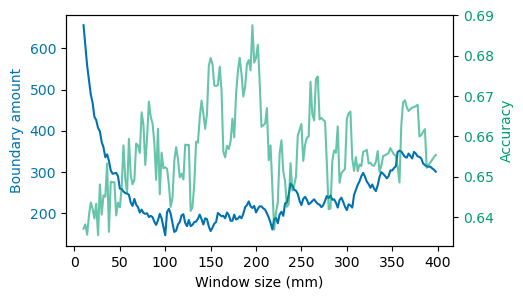

In [25]:
fig, ax1 = plt.subplots(figsize=(5, 3))
ax1.set_xlabel('Window size (mm)')
ax1.set_ylabel('Boundary amount', c='C0')
ax1.plot(windows*2, bds, c='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy', c='C1')
ax2.plot(windows*2, scores, c='C1', alpha=.6)
ax2.tick_params(axis='y', labelcolor='C1')

#fig.tight_layout() 
fig.savefig('results/roll_dev_post_evaluation_{}.png'.format(date))
print(date)

In [27]:
pd.DataFrame(dict(
    window_size_mm=windows*2,
    boundary=bds,
    balanced_score=scores
)).to_csv('results/roll_dev_post_evaluation_{}.csv'.format(date))
print(date)

20210618


## Summary
The post-processing's result looks satisfacory. Both boundary amount and accuracy at the window size range have converging behavior. The boundary amount reduced significantly to around 200, which fit our goal of reducing fragmentation (i.e. 10 times of the human description). Although the accuracy isn't notably increased, it's still an improvement. The trend shows the converging part falls between 134-212 mm window size. I choose 150 mm (75 data points) as the window size since it has the fewest boundary amount and reasonably high accuracy. I focus on the boundary amount a bit more than accuracy because it has more notable improvement differences and it's our main target for this try.

The limited improvement of accuracy, while the fragmentation is siginificantly suppressed, shows there is still other mainly contributing error category, human bias. The sedimentologists have their own bias when comparing to each other, which may be quantitatively described by the difference after Dirk's reclassification. Besides, they use coring locations as their initial knowledge of classification (also including interpretation), which we excluded intentionaly in our data to make the machine "objective". Nevertheless, the post-process of "looking wider" is still different from "looking wider during classification", so it may not fully solved the error caused by looking too narrowlly (i.e. the error category, "XRF can’t or incorrectly depict the composite characteristic as human does, causing the misclassification of fragmented facies" may not be fully eliminated).

Later on I'll write a script to integrate the SVC-roll model and this post-process as our machine. And use it on our test set to write final discussion. But, be cautious, the test set is for describing machine's property, not for optimization.

## Evaluation of the processed predictions

In [4]:
y_df['y_svc_s'] = smooth(y_df.y_svc.values, y_df.core_section.values, 75)

In [9]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

In [7]:
def plot_recall(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test)
    """
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import balanced_accuracy_score as score

    for col in y_preds:
        # make confusion matrix between prediction and actual labels
        confusion = confusion_matrix(data_df.y, data_df[col])
        model_name = col[2:]
        con_df = pd.DataFrame(confusion, index = Facies, columns = Facies)
        #con_df.to_csv('results/roll_confusion_{}_{}.csv'.format(model_name, date))

        # normalize the counts ineach row and present in percent
        x = np.copy(confusion).astype(float)
        x /= x.sum(axis = 1, keepdims = True)
        con_per = pd.DataFrame((x*100).astype(int), index = Facies, columns = Facies)
        #con_per.to_csv('results/roll_recall_%_{}_{}.csv'.format(model_name, date))

        # Plot the matrix
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(con_per, annot = con_per.astype(str), ax = ax, cmap = 'GnBu', square = True, vmin=0, vmax=100,
                    xticklabels = con_per.index, yticklabels = con_per.columns, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Data percentage in each row'}
                   )

        ax.set_xlabel('Prediction (accuracy: {:.2f})'.format(score(y_true=data_df.y, y_pred=data_df[col])), size = 14)
        ax.set_ylabel('Actual facies', size = 14)
        fig.savefig('results/roll_{}_recall_%_{}_{}.png'.format(split, model_name, date))

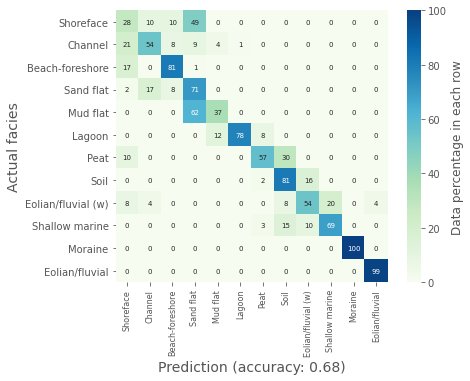

In [10]:
plot_recall(y_df, ['y_svc_s'], Facies, 'dev')

In [11]:
def detect_conjuction(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test).
    """
    
    data_df['id'] = range(len(data_df))
    mat_dict = {}


    for y_pred in y_preds:
        y_mean = []
        composite_id = []
        model_name = y_pred[2:] if len(y_pred)>1 else 'description'
        
        for section in np.unique(data_df.core_section):
            y_mean = np.hstack((y_mean, data_df.loc[data_df.core_section == section, y_pred].rolling(window = 2).mean()))
            composite_id = np.hstack((composite_id, data_df[data_df.core_section == section].index))

        # merge the rolling with the original label
        # this will lost the first data poit in each section, but it doesn't mater
        # because the boundary shouldn't be at the begining of each section
        tmp_df = pd.concat([data_df, pd.DataFrame({'y_mean': y_mean}, index = composite_id).dropna()], join = 'inner', axis = 1)

        # if y_pred is not same as y_mean, it means there is a boundary (facies change) between this and above depth
        bd_df = tmp_df[tmp_df[y_pred] != tmp_df.y_mean].copy()
        bd_df['ab_id'] = bd_df.id - 1
        if len(model_name) > 6:
            print('There are {} boundaries in description.'.format(len(bd_df)))
        else:
            print('There are {} boundaries in the optimized {} model\'s predictions.'.format(len(bd_df), model_name))

        # build matrix of boundaries
        bd_mat = np.zeros(shape = (12, 12), dtype = int)

        for row in bd_df.iterrows():
            tmp = np.zeros(shape = (12, 12), dtype = int)
            tmp[data_df[y_pred][int(row[1].ab_id)], data_df[y_pred][int(row[1].id)]] = 1
            bd_mat += tmp
            
        mat_dict[y_pred] = bd_mat
        
        # plot
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(bd_mat, annot = bd_mat.astype(str), ax = ax, cmap = 'Greens', square = True, #vmin=0, vmax=130,
                    xticklabels = Facies, yticklabels = Facies, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Counts (total: {})'.format(len(bd_df))}
                   )
        ax.set_xlabel('Below facies', size = 16)
        ax.set_ylabel('Above facies', size = 16)
        fig.savefig('results/roll_{}_conjunction_matrix_{}_{}.png'.format(split, model_name, date))
    
    return mat_dict

There are 22 boundaries in description.
There are 157 boundaries in the optimized svc_s model's predictions.


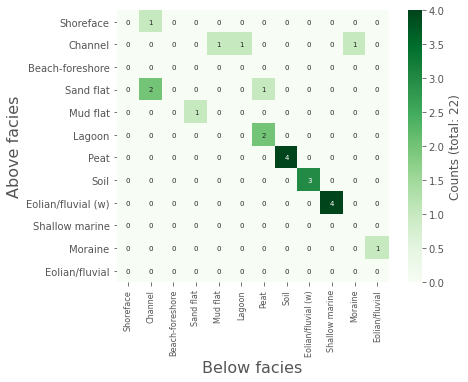

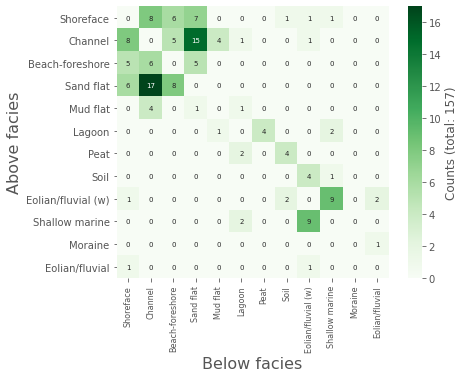

In [12]:
mat_dict = detect_conjuction(y_df,  ['y', 'y_svc_s'], Facies, 'dev')

In [5]:
y_df.to_csv('results/roll_dev_y.csv')

# Sophisticate smotthing
Let's use a section in dev set to develop the codes.
1. transform data to object base, which including information of composite ids, thickness, facies, core section, major "second choice" of facies according to decision scores.
1. add above facies and below facies to the information
1. give thickness criteria for each facies
1. pinpick those facies having too thin thickness to replace them by: voting of above, below and second choice facies. If the voting is equal then simpliy choose the below facie as institution and noted.

In [2]:
from split import my_train_test_split
from joblib import load
svc = load('models/roll_svc_model_20210524.joblib')

data_df = pd.read_csv('data/XRF_ML_cr.csv')
X = data_df.iloc[:, 1:-2].values
y = data_df['facies_merge_2'].values
groups = data_df['core_section'].values

train_idx, test_idx = my_train_test_split(y, groups)
trainn_idx, dev_idx = my_train_test_split(y[train_idx], groups[train_idx])

In [3]:
# actually this step is not necessary...for now
section_codes, section_uniques = data_df.core_section.factorize()
data_df.core_section = section_codes
print(section_codes)
print(section_uniques)

[  0   0   0 ... 346 346 346]
Index(['N10-1', 'N10-2', 'N10-3', 'N10-4', 'N10-5', 'N11-1', 'N11-2', 'N11-3',
       'N11-4', 'N12-1',
       ...
       'W2-2', 'W2-3', 'W3-1', 'W3-2', 'W3-3', 'W4-1', 'W4-2', 'W4-3', 'W5-1',
       'W5-2'],
      dtype='object', length=347)


In [36]:
np.where(uniques == 'N11-2')[0][0]

6

## Build an y dataframe for pilot test

In [25]:
data_df = pd.read_csv('data/XRF_ML_cr.csv')
sections = ['N10-1', 'N10-2', 'N10-3']
data_df.loc[data_df.core_section.isin(sections), data_df.columns[1:-2]]

,Ba_mean,Br_mean,Ca_mean,Cl_mean,Fe_mean,K_mean,Rb_mean,S_mean,Si_mean,Sr_mean,...,Ca_std,Cl_std,Fe_std,K_std,Rb_std,S_std,Si_std,Sr_std,Ti_std,Zr_std
0,-2.149582,-2.301706,3.358506,0.730416,2.535087,1.698956,-1.611358,-1.703103,0.070642,-0.968070,...,0.044595,0.059939,0.059833,0.046311,0.138985,0.136754,0.091019,0.060907,0.053279,0.144020
1,-2.132442,-2.318665,3.353933,0.717854,2.526969,1.695766,-1.613764,-1.686102,0.071552,-0.973912,...,0.044012,0.065340,0.055213,0.044010,0.138831,0.105753,0.091359,0.054621,0.053122,0.131878
2,-2.140558,-2.326715,3.354920,0.710969,2.522705,1.694375,-1.615556,-1.678517,0.082337,-0.972268,...,0.044551,0.070153,0.055973,0.043194,0.138803,0.100158,0.099555,0.055032,0.052643,0.142605
3,-2.132979,-2.343380,3.355639,0.699013,2.512536,1.694095,-1.627726,-1.675207,0.092482,-0.969648,...,0.044925,0.080911,0.065025,0.043231,0.143668,0.096235,0.098671,0.054823,0.052619,0.170292
4,-2.132173,-2.369807,3.354430,0.687102,2.499641,1.693513,-1.622623,-1.676050,0.111802,-0.976699,...,0.045268,0.085312,0.080550,0.043524,0.137869,0.096651,0.102500,0.061061,0.053835,0.226116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,-1.009189,-4.391355,2.637722,1.764963,1.261536,1.988633,-1.190279,-1.755177,2.052662,-0.733905,...,0.278543,0.175711,0.187906,0.194333,0.321490,0.259498,0.182021,0.248222,0.289756,0.396157
1532,-1.027851,-4.411884,2.672701,1.753051,1.271556,1.986175,-1.197248,-1.748551,2.035061,-0.717179,...,0.293180,0.165596,0.202204,0.192571,0.313241,0.266382,0.171385,0.251252,0.272511,0.374621
1533,-1.033824,-4.444322,2.717755,1.747530,1.301327,1.989017,-1.202668,-1.756047,2.025749,-0.708863,...,0.245182,0.174672,0.176183,0.189805,0.314737,0.270675,0.185439,0.238175,0.260743,0.334780
1534,-1.036054,-4.460709,2.733407,1.746445,1.305069,1.982315,-1.206325,-1.755007,2.020693,-0.714730,...,0.252098,0.174225,0.178836,0.183145,0.311946,0.270153,0.181902,0.233142,0.281405,0.340502


In [26]:
y_df = pd.DataFrame(svc.decision_function(data_df.loc[data_df.core_section.isin(sections), data_df.columns[1:-2]]))
y_df['y_pred'] = svc.predict(data_df.loc[data_df.core_section.isin(sections), data_df.columns[1:-2]])
y_df

,0,1,2,3,4,5,6,7,8,9,10,11,y_pred
0,10.309433,11.317898,5.762971,8.303506,9.306550,6.272144,2.709645,-0.320271,1.695064,6.239202,3.767956,0.687008,1
1,10.308632,11.317661,5.749544,9.305015,8.305499,6.269514,2.710304,-0.319802,1.695554,6.235503,3.760411,0.687830,1
2,9.308319,11.317855,5.756782,10.306000,8.304762,6.269417,2.709435,-0.319847,1.695380,6.240689,3.751866,0.687757,1
3,9.308975,11.317692,5.747212,10.306616,8.306236,6.257196,2.714341,-0.319968,1.695610,6.242324,3.743925,0.687615,1
4,9.309076,11.317859,5.744340,10.307842,8.305576,6.251854,3.716662,-0.320135,1.695612,6.257916,2.732645,0.687377,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,11.313919,9.309043,10.306018,8.264525,3.714018,0.688575,1.700752,2.702866,6.197301,7.256144,1.707392,2.729783,0
1532,11.314067,9.309528,10.304388,8.259612,3.714861,0.689106,1.698905,2.705904,6.193602,7.258613,1.708134,2.726806,0
1533,11.314019,9.309041,10.307260,8.260670,3.715675,0.687605,1.701444,2.705686,6.189496,7.236668,1.713262,2.721178,0
1534,11.314417,9.309361,10.306659,8.261619,3.721251,-0.312621,2.701231,2.705105,6.171333,7.231102,1.713639,2.718944,0


In [28]:
y_df.index = data_df.index[data_df.core_section.isin(sections)]
y_df = pd.concat([y_df, data_df.loc[data_df.core_section.isin(sections), ['composite_id', 'core_section']]], axis=1, join='inner')
y_df

,0,1,2,3,4,5,6,7,8,9,10,11,y_pred,composite_id,core_section
0,10.309433,11.317898,5.762971,8.303506,9.306550,6.272144,2.709645,-0.320271,1.695064,6.239202,3.767956,0.687008,1,N10_03460,N10-1
1,10.308632,11.317661,5.749544,9.305015,8.305499,6.269514,2.710304,-0.319802,1.695554,6.235503,3.760411,0.687830,1,N10_03462,N10-1
2,9.308319,11.317855,5.756782,10.306000,8.304762,6.269417,2.709435,-0.319847,1.695380,6.240689,3.751866,0.687757,1,N10_03464,N10-1
3,9.308975,11.317692,5.747212,10.306616,8.306236,6.257196,2.714341,-0.319968,1.695610,6.242324,3.743925,0.687615,1,N10_03466,N10-1
4,9.309076,11.317859,5.744340,10.307842,8.305576,6.251854,3.716662,-0.320135,1.695612,6.257916,2.732645,0.687377,1,N10_03468,N10-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,11.313919,9.309043,10.306018,8.264525,3.714018,0.688575,1.700752,2.702866,6.197301,7.256144,1.707392,2.729783,0,N10_02311,N10-3
1532,11.314067,9.309528,10.304388,8.259612,3.714861,0.689106,1.698905,2.705904,6.193602,7.258613,1.708134,2.726806,0,N10_02313,N10-3
1533,11.314019,9.309041,10.307260,8.260670,3.715675,0.687605,1.701444,2.705686,6.189496,7.236668,1.713262,2.721178,0,N10_02315,N10-3
1534,11.314417,9.309361,10.306659,8.261619,3.721251,-0.312621,2.701231,2.705105,6.171333,7.231102,1.713639,2.718944,0,N10_02317,N10-3


## Transform to object base

In [29]:
def return_do(ar):
    """
    This function can return the dominant facies among the list of facies.
    If the amount of facies are equal, the facies corresponding to the first sorted occurrence is returned.
    This is due to the rule of np.argmax().
    """
    uniques, counts = np.unique(ar, return_counts=True)
    return uniques[np.argmax(counts)]

In [30]:
print(return_do([1, 1, 1, 2]))
print(return_do([1, 1, 2, 2]))

1
1


In [31]:
def detect_object(y_df):
    """
    The y_df needs to be a pd.DataFrame containing decision scores on each facies (X12), 
    prediction (y), core section and composite_id.
    """
    id_ob = []
    thick_ob = []
    fa_ob = []
    fa_sec_ob = []
    section_ob = []

    # initialize, the values will be deleted at the end
    fa = -1
    section = -1
    id_list = [1]
    fa_sec_list = [1]


    for _, row in y_df.iterrows():
        # refresh when facies or core section changes
        if row.y_pred != fa or row.core_section != section:
            # record the previoius infos
            id_ob.append(id_list)
            ## I simply use the data amount to calculate thickness
            ## this way may lead to wrong thickness when there are missing
            ## data due to low data quality, but I don't think it matters a lot
            ## resolution: 2 mm
            thick_ob.append(len(id_list)*2)
            fa_ob.append(fa)
            fa_sec_ob.append(return_do(fa_sec_list))
            section_ob.append(section)

            # refresh
            id_list = [row.composite_id]
            fa = row.y_pred
            fa_sec_list = [np.argsort(row[:12].values)[-2]]
            section = row.core_section
        else:
            id_list.append(row.composite_id)
            # pick up the facies having second high score
            fa_sec_list.append(np.argsort(row[:12].values)[-2])

    # append the last object, which can't be recorded by above codes 
    # because there is no change in y_pred or core section after it        
    id_ob.append(id_list)
    thick_ob.append(len(id_list)*2)
    fa_ob.append(fa)
    fa_sec_ob.append(return_do(fa_sec_list))
    section_ob.append(section)   
    
    # drop the first row, which records the initial infos
    return np.stack([np.array(id_ob, dtype=object), section_ob, thick_ob, fa_ob, fa_sec_ob], axis=0)[:, 1:]    

In [32]:
units = detect_object(y_df)
units[:, 1]

array([list(['N10_03598', 'N10_03600', 'N10_03602', 'N10_03604', 'N10_03606', 'N10_03608', 'N10_03610', 'N10_03612', 'N10_03614', 'N10_03616', 'N10_03618', 'N10_03620', 'N10_03622', 'N10_03624', 'N10_03626', 'N10_03628', 'N10_03630', 'N10_03632', 'N10_03634', 'N10_03636', 'N10_03638', 'N10_03640', 'N10_03642', 'N10_03644', 'N10_03646', 'N10_03648', 'N10_03650', 'N10_03652', 'N10_03654', 'N10_03656', 'N10_03658']),
       'N10-1', 62, 0, 1], dtype=object)

In [33]:
# check if all rows are gone through
ct=0
for _ in units[0]:
    ct+=len(_)
print(ct)

1536


It same as the row amount of the y_df

In [34]:
units.shape

(5, 80)

1536 data points are transformed into 80 objects. BTW, the id is in ascendence within each core section, so the ordering in depth is taken care as long as the execution is section by section.

In [35]:
units_df = pd.DataFrame(units.T, columns=['composite_id', 'core_section', 'thickness_mm', 'facies', 'facies_second'])
units_df

,composite_id,core_section,thickness_mm,facies,facies_second
0,"[N10_03460, N10_03462, N10_03464, N10_03466, N...",N10-1,138,1,3
1,"[N10_03598, N10_03600, N10_03602, N10_03604, N...",N10-1,62,0,1
2,"[N10_03660, N10_03662, N10_03664, N10_03666, N...",N10-1,54,1,0
3,"[N10_03716, N10_03718, N10_03720, N10_03722, N...",N10-1,200,0,1
4,"[N10_03916, N10_03918, N10_03920]",N10-1,6,1,0
...,...,...,...,...,...
75,"[N10_02167, N10_02169, N10_02171, N10_02173, N...",N10-3,70,1,3
76,"[N10_02237, N10_02239, N10_02241, N10_02243, N...",N10-3,18,3,0
77,[N10_02255],N10-3,2,0,3
78,"[N10_02257, N10_02259, N10_02261, N10_02263, N...",N10-3,24,3,0


### Check 
if there are same second facies with the predicted facies, which is the one having highest decision score.

In [36]:
units_df[(units_df.facies - units_df.facies_second) == 0]

,composite_id,core_section,thickness_mm,facies,facies_second
22,[N10_04372],N10-1,2,0,0
24,[N10_04376],N10-1,2,0,0
44,"[N10_02923, N10_02925, N10_02927, N10_02929]",N10-2,8,0,0


Hmm...there three objects having this issue.

In [37]:
y_df[y_df.composite_id == 'N10_04372']

,0,1,2,3,4,5,6,7,8,9,10,11,y_pred,composite_id,core_section
455,10.313197,10.318096,10.310573,8.311657,6.85393,1.697125,3.720448,1.688965,3.708145,5.76043,1.705429,0.684791,0,N10_04372,N10-1


In [38]:
np.argsort(y_df.iloc[455, :12].values)[-2]

0

In [39]:
y_df[y_df.composite_id == 'N10_04376']

,0,1,2,3,4,5,6,7,8,9,10,11,y_pred,composite_id,core_section
457,10.312849,10.318265,10.310557,8.309621,7.140215,1.699343,4.71639,1.68965,3.706085,4.761136,1.702216,0.685142,0,N10_04376,N10-1


In [40]:
np.argsort(y_df.iloc[457, :12].values)[-2]

0

These two both having every close scores in the first three facies. The problem happened at the prediction. The machine didn't choose the facies having highest score, so when our codes choose the facies having second high score, they coresponse.

In [41]:
y_df[y_df.composite_id == 'N10_02923']

,0,1,2,3,4,5,6,7,8,9,10,11,y_pred,composite_id,core_section
774,11.318318,10.322255,7.222418,9.318565,8.300905,6.173276,1.686177,-0.321715,2.689665,5.253718,2.696671,1.682514,0,N10_02923,N10-2


In [42]:
for _, row in y_df.iloc[774:778, :12].iterrows():
    print(np.argsort(row.values)[-2])

1
0
0
0


This object having the issue because its dominant second high score is 0, by occasion.

## Add more infos to the df
Add above and below facies of each object core section by core section. If there no above/below facies,  it is None.

In [45]:
def add_facies(units_df):
    """
    The units_df needs to be the pd.DataFrame of the transposed matrix of detect_object(),
    having 'composite_id', 'core_section', 'thickness_mm', 'facies', 'facies_second' as columns.
    """
    fa_ab = []
    fa_bl = []
    ct = 0
    for section in units_df.core_section.unique():
        X = units_df[units_df.core_section == section].copy()
        for i in X.index:
            try:
                fa_ab.append(X.facies[i-1])
            except KeyError:
                fa_ab.append(None)
            try:
                fa_bl.append(X.facies[i+1])
            except KeyError:
                fa_bl.append(None)
                ct+=1
    return fa_ab, fa_bl, ct

In [46]:
fa_ab, fa_bl, ct = add_facies(units_df)
print(ct)
print(len(fa_ab), len(fa_bl))
print(len(units_df))

3
80 80
80


There are three ends of core section so the count matches.

In [47]:
for i in range(len(fa_ab)):
    print(fa_ab[i], fa_bl[i])

None 0
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 0
1 1
0 2
1 0
2 2
0 0
2 1
0 None
None 1
3 0
1 1
0 0
1 1
0 0
1 1
0 3
1 1
3 3
1 1
3 3
1 1
3 0
1 2
0 0
2 1
0 0
1 1
0 3
1 1
3 None
None 1
0 0
1 1
0 0
1 1
0 0
1 1
0 3
1 1
3 0
1 1
0 0
1 1
0 0
1 3
0 0
3 3
0 1
3 3
1 0
3 3
0 0
3 1
0 0
1 1
0 3
1 1
3 3
1 0
3 3
0 0
3 None


In [48]:
units_df['facies_above'] = fa_ab
units_df['facies_below'] = fa_bl
units_df

,composite_id,core_section,thickness_mm,facies,facies_second,facies_above,facies_below
0,"[N10_03460, N10_03462, N10_03464, N10_03466, N...",N10-1,138,1,3,NaN,0.0
1,"[N10_03598, N10_03600, N10_03602, N10_03604, N...",N10-1,62,0,1,1.0,1.0
2,"[N10_03660, N10_03662, N10_03664, N10_03666, N...",N10-1,54,1,0,0.0,0.0
3,"[N10_03716, N10_03718, N10_03720, N10_03722, N...",N10-1,200,0,1,1.0,1.0
4,"[N10_03916, N10_03918, N10_03920]",N10-1,6,1,0,0.0,0.0
...,...,...,...,...,...,...,...
75,"[N10_02167, N10_02169, N10_02171, N10_02173, N...",N10-3,70,1,3,3.0,3.0
76,"[N10_02237, N10_02239, N10_02241, N10_02243, N...",N10-3,18,3,0,1.0,0.0
77,[N10_02255],N10-3,2,0,3,3.0,3.0
78,"[N10_02257, N10_02259, N10_02261, N10_02263, N...",N10-3,24,3,0,0.0,0.0


Be aware, the above and blow facies are in float dtype, so cautions needed later doing voting.

## Build function for voting

In [74]:
# toy data
test = units_df.iloc[0, -3:]
test

facies_second      3
facies_above     NaN
facies_below     0.0
Name: 0, dtype: object

In [82]:
def vote(series):
    """
    The series must be pd.Series having facies_second, facies_above and facies_below as columns.
    This function can return the dominant facies among the list of facies (dominant second, above and below facies).
    If the amount of facies are equal, the above facies is returned. If the above facies is missing, the below facies is returned.
    This is different from return_do().
    """
    series = series.astype(float)
    uniques, counts = np.unique(series, return_counts=True)
    if series.facies_second != series.facies_above != series.facies_below:
        try:
            return int(series.facies_above)
        except ValueError: # when above facies is None
            return int(series.facies_below)
    else:
        return int(uniques[np.argmax(counts)])

In [83]:
vote(test)

0

## Build function for replacing facies

In [84]:
def replace(series):
    """
    The series need to be pd.Series having facies, thickness_mm,
    facies_second, facies_above and facies_below as columns.
    """
    
    thickness_dict = {
        # Shoreface
        '0': 100,
        # Channel
        '1': 100, 
        # Beach-foreshore
        '2': 100,
        # Sand flat
        '3': 100,
        # Mud flat
        '4': 100,
        # Lagoon
        '5': 50,
        # Peat
        '6': 50,
        # Soil
        '7': 30,
        # Eolian/fluvial (w)
        '8': 200,
        # Shallow marine
        '9': 200,
        # Moraine
        '10': 200,
        # Eolian/fluvial
        '11': 200
    }
    
    if series.thickness_mm < thickness_dict[str(series.facies)]:
        return vote(series[-3:])
    else:
        return series.facies

In [194]:
fa_new = []
for _, row in units_df.iterrows():
    fa_new.append(replace(row))

In [85]:
units_df['facies_replaced'] = units_df.apply(replace, axis=1)
units_df

,composite_id,core_section,thickness_mm,facies,facies_second,facies_above,facies_below,facies_replaced
0,"[N10_03460, N10_03462, N10_03464, N10_03466, N...",N10-1,138,1,3,NaN,0.0,1
1,"[N10_03598, N10_03600, N10_03602, N10_03604, N...",N10-1,62,0,1,1.0,1.0,1
2,"[N10_03660, N10_03662, N10_03664, N10_03666, N...",N10-1,54,1,0,0.0,0.0,0
3,"[N10_03716, N10_03718, N10_03720, N10_03722, N...",N10-1,200,0,1,1.0,1.0,0
4,"[N10_03916, N10_03918, N10_03920]",N10-1,6,1,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
75,"[N10_02167, N10_02169, N10_02171, N10_02173, N...",N10-3,70,1,3,3.0,3.0,3
76,"[N10_02237, N10_02239, N10_02241, N10_02243, N...",N10-3,18,3,0,1.0,0.0,1
77,[N10_02255],N10-3,2,0,3,3.0,3.0,3
78,"[N10_02257, N10_02259, N10_02261, N10_02263, N...",N10-3,24,3,0,0.0,0.0,0


In [196]:
units_df.to_csv('results/objectize_replacement_pilot_{}.csv'.format(date))

The result seems to be fine, except those objects adjent with fragmented objects can't be smoothed properly.

## Transform back to data point base

In [110]:
ids = []
y_s = []

for _, row in units_df.iterrows():
    for composite_id in row.composite_id:
        ids.append(composite_id)
        y_s.append(row.facies_replaced)

In [115]:
y_df = pd.concat([y_df.set_index('composite_id'), pd.DataFrame(y_s, index=ids, columns=['y_smooth'])], join='inner', axis=1)
y_df

,0,1,2,3,4,5,6,7,8,9,10,11,y_pred,core_section,y_smooth
N10_03460,10.309433,11.317898,5.762971,8.303506,9.306550,6.272144,2.709645,-0.320271,1.695064,6.239202,3.767956,0.687008,1,N10-1,1
N10_03462,10.308632,11.317661,5.749544,9.305015,8.305499,6.269514,2.710304,-0.319802,1.695554,6.235503,3.760411,0.687830,1,N10-1,1
N10_03464,9.308319,11.317855,5.756782,10.306000,8.304762,6.269417,2.709435,-0.319847,1.695380,6.240689,3.751866,0.687757,1,N10-1,1
N10_03466,9.308975,11.317692,5.747212,10.306616,8.306236,6.257196,2.714341,-0.319968,1.695610,6.242324,3.743925,0.687615,1,N10-1,1
N10_03468,9.309076,11.317859,5.744340,10.307842,8.305576,6.251854,3.716662,-0.320135,1.695612,6.257916,2.732645,0.687377,1,N10-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N10_02311,11.313919,9.309043,10.306018,8.264525,3.714018,0.688575,1.700752,2.702866,6.197301,7.256144,1.707392,2.729783,0,N10-3,3
N10_02313,11.314067,9.309528,10.304388,8.259612,3.714861,0.689106,1.698905,2.705904,6.193602,7.258613,1.708134,2.726806,0,N10-3,3
N10_02315,11.314019,9.309041,10.307260,8.260670,3.715675,0.687605,1.701444,2.705686,6.189496,7.236668,1.713262,2.721178,0,N10-3,3
N10_02317,11.314417,9.309361,10.306659,8.261619,3.721251,-0.312621,2.701231,2.705105,6.171333,7.231102,1.713639,2.718944,0,N10-3,3


In [120]:
y_df['y'] = data_df.loc[data_df.core_section.isin(sections), 'facies_merge_2'].values

In [122]:
from sklearn.metrics import balanced_accuracy_score as score
print('Balanced score: {:.2f}'.format(score(y_true=y_df.y, y_pred=y_df.y_smooth)))

Balanced score: 0.63


/home/users/aslee/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [123]:
count_boundary(y_df.y_smooth, y_df.core_section)

63

## Build a script and apply to dev set
The script (post_process.py) is build based on the codes above. Meanwhile, I apply the smoothing to the whole dev set to see how it works comparing to the simple smoothing.

In [14]:
objects_df = pd.read_csv('results/roll_post_obj_dev_20210721.csv', index_col=0)
objects_df

,composite_id,core_section,thickness_mm,facies,facies_second,facies_above,facies_below,facies_replaced
0,"['N11_01652', 'N11_01654', 'N11_01656', 'N11_0...",N11-2,60,1,0,NaN,0.0,0
1,"['N11_01728', 'N11_01730', 'N11_01732', 'N11_0...",N11-2,60,0,1,1.0,1.0,1
2,"['N11_01792', 'N11_01798', 'N11_01800', 'N11_0...",N11-2,60,1,0,0.0,0.0,0
3,"['N11_01856', 'N11_01858', 'N11_01860', 'N11_0...",N11-2,60,0,1,1.0,1.0,1
4,"['N11_01916', 'N11_01918', 'N11_01932', 'N11_0...",N11-2,30,1,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
416,"['W3_02187', 'W3_02189', 'W3_02191', 'W3_02193...",W3-1,60,0,6,NaN,6.0,6
417,"['W3_02247', 'W3_02249', 'W3_02251', 'W3_02253...",W3-1,90,6,0,0.0,7.0,6
418,"['W3_02337', 'W3_02339', 'W3_02341', 'W3_02343...",W3-1,270,7,6,6.0,8.0,7
419,"['W3_02607', 'W3_02609', 'W3_02611', 'W3_02613...",W3-1,30,8,7,7.0,7.0,7


In [15]:
y_df = pd.read_csv('results/roll_post_y_dev_20210721.csv', index_col=0)
y_df

,0,1,2,3,4,5,6,7,8,9,10,11,y,y_pred,y_pred_s,core_section,y_smooth
N11_01652,8.287312,11.315825,9.280486,9.308746,1.694607,-0.300491,2.690156,4.717874,5.052767,6.093337,0.688942,7.303088,0,1,1,N11-2,0
N11_01654,8.284151,11.316335,9.284267,9.310099,2.695225,-0.304666,1.687406,3.708650,6.254377,6.229600,0.689489,7.296107,0,1,1,N11-2,0
N11_01656,8.287777,11.314842,9.287163,9.309063,2.703635,-0.305635,1.689253,3.703470,6.243105,6.195918,0.694307,7.282118,0,1,1,N11-2,0
N11_01658,10.310175,11.316387,8.238799,9.310987,2.725708,-0.298509,1.692020,3.708965,5.753967,5.861158,0.691719,5.900951,0,1,1,N11-2,0
N11_01660,10.309762,11.316664,8.207532,9.310169,4.740395,0.704647,1.692106,1.704957,5.767658,4.973581,0.691450,5.815774,0,1,1,N11-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W3_03105,3.815989,4.744368,1.684113,7.296191,1.686548,3.717003,10.315171,11.317208,8.319166,9.316486,-0.321393,3.687017,8,7,7,W3-1,7
W3_03107,4.841029,3.743302,2.684765,7.300771,1.686844,1.711260,10.314031,11.316907,8.318904,9.316075,-0.321632,4.688812,8,7,7,W3-1,7
W3_03109,3.763880,4.735125,2.685669,7.298234,0.685362,1.712736,10.315276,11.317277,8.319042,9.317273,-0.322174,5.690439,8,7,7,W3-1,7
W3_03111,3.779372,4.744939,2.686221,7.297645,0.684634,1.711997,10.314581,11.316906,8.318979,9.317483,-0.322184,5.691192,8,7,7,W3-1,7


In [19]:
from sklearn.metrics import balanced_accuracy_score as score
from post_process import count_boundary

print('Balanced score of the prediction: {:.2f}'.format(score(y_true=y_df.y, y_pred=y_df.y_pred)))
print('Balanced score after simple smoothing: {:.2f}'.format(score(y_true=y_df.y, y_pred=y_df.y_pred_s)))
print('Balanced score after sophisticate smoothing: {:.2f}'.format(score(y_true=y_df.y, y_pred=y_df.y_smooth)))

print('Boundary amount of the prediction: {}'.format(count_boundary(y_df.y_pred, y_df.core_section)))
print('Boundary amount after simple smoothing: {}'.format(count_boundary(y_df.y_pred_s, y_df.core_section)))
print('Boundary amount after sophisticate smoothing: {}'.format(count_boundary(y_df.y_smooth, y_df.core_section)))
print('Boundary amount of description: {}'.format(count_boundary(y_df.y, y_df.core_section)))

Balanced score of the prediction: 0.64
Balanced score after simple smoothing: 0.64
Balanced score after sophisticate smoothing: 0.66
Boundary amount of the prediction: 1327
Boundary amount after simple smoothing: 373
Boundary amount after sophisticate smoothing: 243
Boundary amount of description: 22


In [22]:
from evaluation import *

Facies = get_Facies()
mat_dict = detect_conjuction(y_df, ['y', 'y_pred', 'y_pred_s', 'y_smooth'])

There are 22 boundaries in description.
There are 1327 boundaries in the optimized pred model's predictions.
There are 373 boundaries in the optimized pred_s model's predictions.
There are 243 boundaries in the optimized smooth model's predictions.


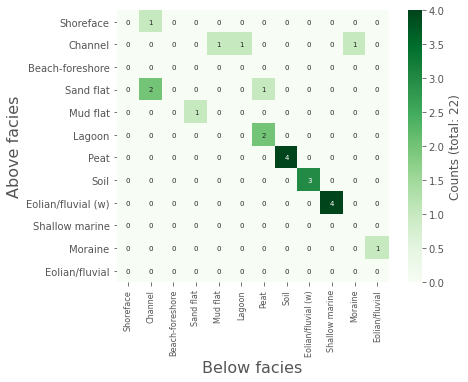

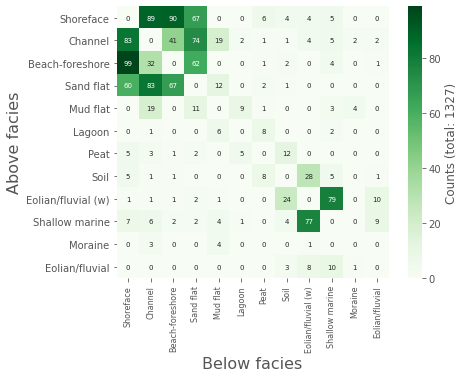

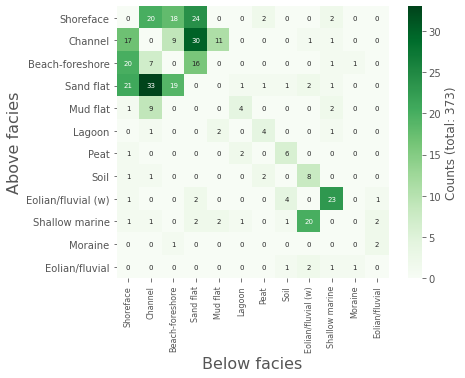

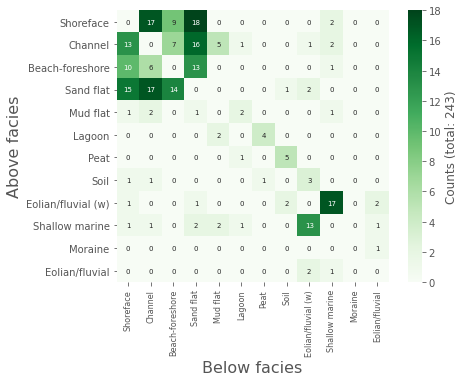

In [27]:
split = 'dev'
for model_name in ['y', 'y_pred', 'y_pred_s', 'y_smooth']:
    fig, ax = plt.subplots(1, 1, figsize = (7, 5))
    sns.heatmap(mat_dict[model_name], annot = mat_dict[model_name].astype(str), ax = ax, cmap = 'Greens', square = True, #vmin=0, vmax=130,
                xticklabels = Facies, yticklabels = Facies, fmt = 's', 
                annot_kws={'size': 7}, cbar_kws = {'label' : 'Counts (total: {})'.format(np.sum(mat_dict[model_name]))}
               )
    ax.set_xlabel('Below facies', size = 16)
    ax.set_ylabel('Above facies', size = 16)
    fig.savefig('results/roll_{}_conjunction_matrix_{}_{}.png'.format(split, model_name, date))